In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from ml_time_series import generate_envelope
import timeit
from datetime import datetime
from sklearn.externals import joblib

In [3]:
import smtplib
from email.MIMEMultipart import MIMEMultipart
from email.MIMEText import MIMEText
from email.mime.image import MIMEImage

def send_email(text, img=False ,toaddr='jorgeluizjk@gmail.com'):
    fromaddr = 'ohperaml@gmail.com'
    passw = 'ohperaml11'
    msg = MIMEMultipart()
    msg['From'] = fromaddr
    msg['To'] = toaddr
    msg['Subject'] = "Jupyter - Processing completed"

    body = 'Processing completed\n' + text
    msg.attach(MIMEText(body, 'plain'))
    
    if img!=False:
        img_data = open(img, 'rb').read()
        image = MIMEImage(img_data, name=os.path.basename(img))
        msg.attach(image)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(fromaddr, passw)
    text = msg.as_string()
    server.sendmail(fromaddr, toaddr, text)
    server.quit()

In [128]:
files = ['data_154743','data_155334','data_155743','data_161034', 'data_161420', 'rob_data_170159', 'bru_data_170623']

DATAFILE = np.load('DB_HAND/'+files[0]+'.npy')
df = pd.DataFrame(DATAFILE, columns=['Sample','Label'])

df.head()

,Sample,Label
0,484.0,0.0
1,493.0,0.0
2,506.0,0.0
3,490.0,0.0
4,512.0,0.0


In [119]:
DATAFILE.shape

(30000, 2)

<IPython.core.display.Javascript object>


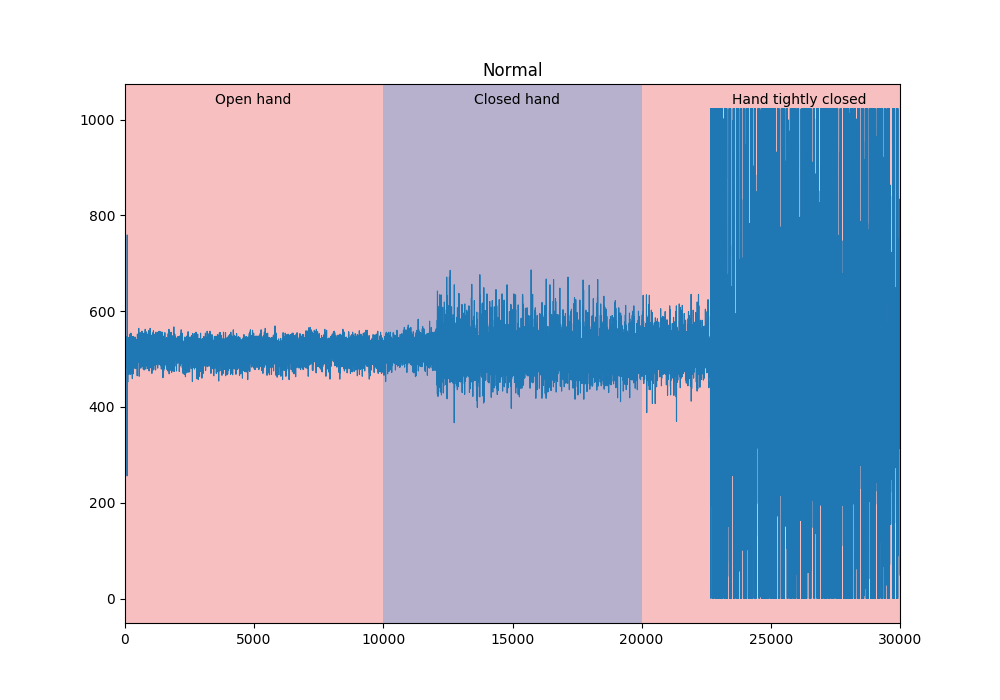

In [120]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()

df['Sample'].plot(linewidth=0.8)
plt.title('Normal')

plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
plt.annotate('Open hand', xy=(3500, df['Sample'].max()*1.01))  
plt.annotate('Closed hand', xy=(13500, df['Sample'].max()*1.01))
plt.annotate('Hand tightly closed', xy=(23500, df['Sample'].max()*1.01))

#fig_name = 'fig_' + files[0] + '.png'
fig.set_size_inches(w=10,h=7)
#fig.savefig(fig_name)

---
# Filtering
---

### RMS Function

In [34]:
import numpy as np
def window_rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

<IPython.core.display.Javascript object>


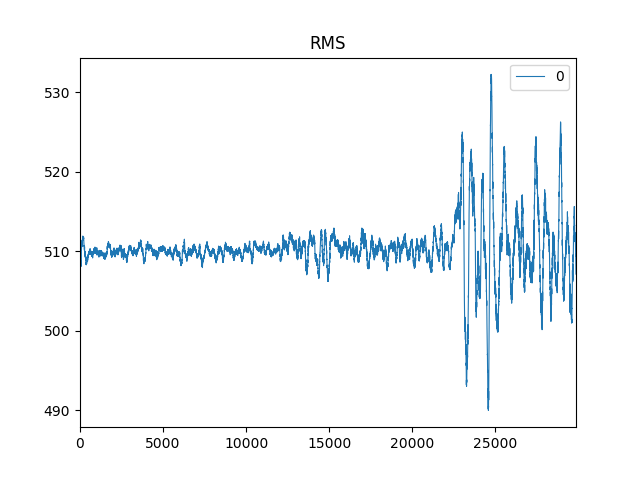

In [35]:
rms = window_rms(df['Sample'],150)

df_rms = pd.DataFrame(rms)

df_rms.plot(linewidth=0.8)
plt.title('RMS')

### Filter Function

In [36]:
def filteremg(time, emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    time: Time data
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

def plot_fremg(df):   
    # plot graphs
    fig = plt.figure()
    

    #plt.subplot(4, 1, 1).xaxis.set_visible(False)
    #plt.plot.set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(40)) + ' Hz' + '\n VL-d')
    plt.plot(fr_emg['Time'], fr_emg['Filtered'])
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
    plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
    plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
    plt.annotate('Open hand', xy=(3500, fr_emg['Filtered'].max()))  
    plt.annotate('Closed hand', xy=(13500, fr_emg['Filtered'].max()))
    plt.annotate('Hand tightly closed', xy=(23500, fr_emg['Filtered'].max()))
        

    #fig_name = 'fig_' + files[0] + '_filtered.png'
    #fig.set_size_inches(w=11,h=7)
    #fig.savefig(fig_name)



<IPython.core.display.Javascript object>


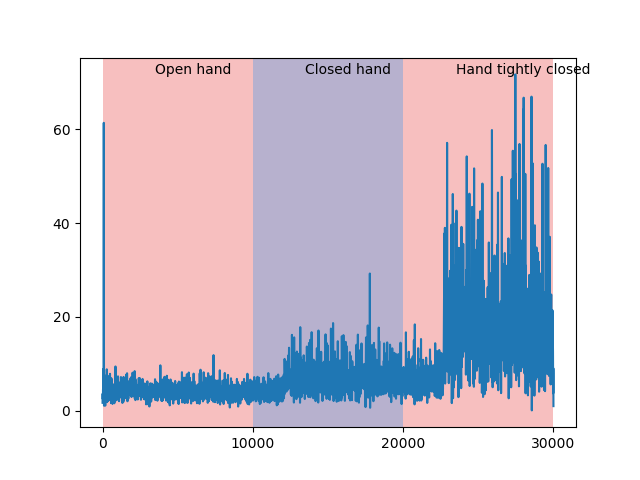

In [37]:
df['Time'] = (range(0,len(df)))
# show what different low pass filter cut-offs do
fr_emg = pd.DataFrame(df['Time'])

emg_correctmean = np.array(df['Sample'])
fr_emg['Filtered'] = pd.DataFrame(filteremg(df['Time'], emg_correctmean, low_pass=180))


plot_fremg(fr_emg)

### Process automation

In [4]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [48]:
def plot_fremg(data):   
    # plot graphs
    fig = plt.figure()
    

    #plt.subplot(4, 1, 1).xaxis.set_visible(False)
    #plt.plot.set_title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(40)) + ' Hz' + '\n VL-d')
    plt.plot(data)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(.0, 9999, facecolor='#F08080', alpha=0.5)
    plt.axvspan(10000, 19999, facecolor='#70659e', alpha=0.5)
    plt.axvspan(20000, 29999, facecolor='#F08080', alpha=0.5)
    plt.annotate('Open hand', xy=(3500, data.max()))  
    plt.annotate('Closed hand', xy=(13500, data.max()))
    plt.annotate('Hand tightly closed', xy=(23500, data.max()))
        

    #fig_name = 'fig_' + str(int(40)) + '.png'
    fig.set_size_inches(w=10,h=7)
    #fig.savefig(fig_name)

In [197]:
#plt.figure()
#plt.plot(filter_signal(df['Sample'], low_pass=3)[50:])

In [13]:
data = np.load('DB_HAND/'+'data_154743'+'.npy')

In [14]:
data = filter_signal(data[:,0], low_pass=3)

In [22]:
#plt.plot(data)

---
# Processing
---

In [63]:
def proccess_data(file_,DATA):

    #Load data and filter
    data = np.load('DB_HAND/'+file_+'.npy')
    #data = window_rms(data[:,0], 150)
    data = filter_signal(data[:,0], low_pass=180)
    #plot_fremg(data)
    #Xc_1 = data[:10000]
    #Xc_2 = data[10000:20000]
    #Xc_3 = data[20000:]

    Xc_1 = data[3000:10000]
    Xc_2 = data[13000:20000]
    Xc_3 = data[23000:]
    
    print '\nXc_1 filtered shape ', Xc_1.shape
    print 'Xc_2 filtered shape ', Xc_2.shape
    print 'Xc_3 filtered shape ', Xc_3.shape
    
    #Create temporal serie
    NUM_SAMPLES = 500
    
    Xc_1 = generate_envelope(Xc_1, NUM_SAMPLES)
    Xc_2 = generate_envelope(Xc_2, NUM_SAMPLES)
    Xc_3 = generate_envelope(Xc_3, NUM_SAMPLES)
    
    print 'Xc_1 temporal-serie shape ', Xc_1.shape
    print 'Xc_2 temporal-serie shape ', Xc_2.shape
    print 'Xc_3 temporal-serie shape ', Xc_3.shape
    
    #Labeling the type of movement
    C = (np.ones(len(Xc_1))*0).reshape((len(Xc_1),1))
    Xc_1 = np.hstack((Xc_1.reshape(Xc_1.shape),C.reshape((len(Xc_1),1))))


    C = (np.ones(len(Xc_2))*1).reshape((len(Xc_2),1))
    Xc_2 = np.hstack((Xc_2.reshape(Xc_2.shape),C.reshape((len(Xc_2),1))))
    
    C = (np.ones(len(Xc_3))*2).reshape((len(Xc_3),1))
    Xc_3 = np.hstack((Xc_3.reshape(Xc_3.shape),C.reshape((len(Xc_3),1))))
    
    print 'Xc_1 labeled shape ', Xc_1.shape
    print 'Xc_2 labeled shape ', Xc_2.shape
    print 'Xc_3 labeled shape ', Xc_3.shape
    
    # Salving in file on the folder <classifier_data>
    np.save('./preproc_filtered_data/'+file_+'_f_honp', Xc_1, allow_pickle=False)
    print file_+'_f_honp'+'.npy'    
    
    np.save('./preproc_filtered_data/'+file_+'_f_hclp', Xc_2, allow_pickle=False)
    print file_+'_f_hclp'+'.npy'

    np.save('./preproc_filtered_data/'+file_+'_f_hchp', Xc_3, allow_pickle=False)
    print file_+'_f_hchp'+'.npy'
    
    
    DATA.append(file_+'_f_honp.'+'npy')
    DATA.append(file_+'_f_hclp.'+'npy')
    DATA.append(file_+'_f_hchp.'+'npy')

<IPython.core.display.Javascript object>


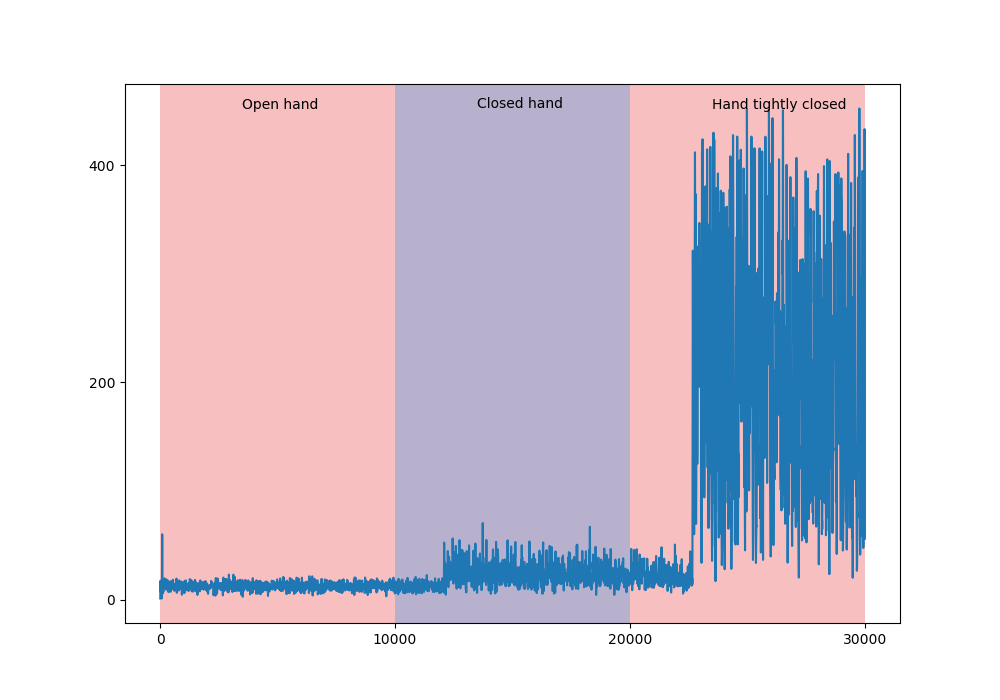


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
data_154743_f_honp.npy
data_154743_f_hclp.npy
data_154743_f_hchp.npy


<IPython.core.display.Javascript object>


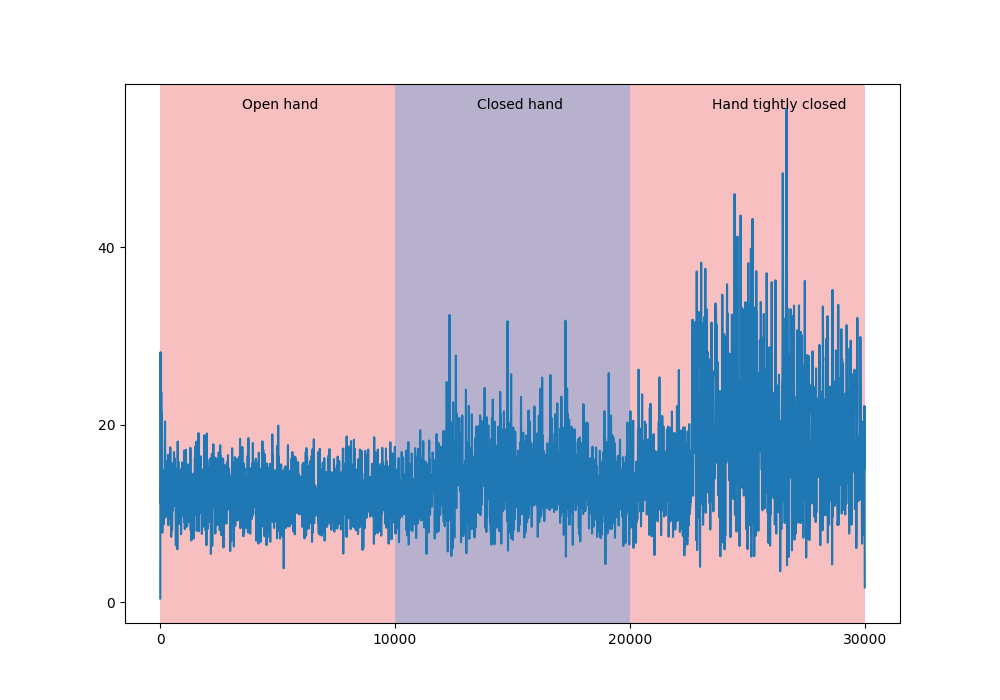


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
data_155334_f_honp.npy
data_155334_f_hclp.npy
data_155334_f_hchp.npy


<IPython.core.display.Javascript object>


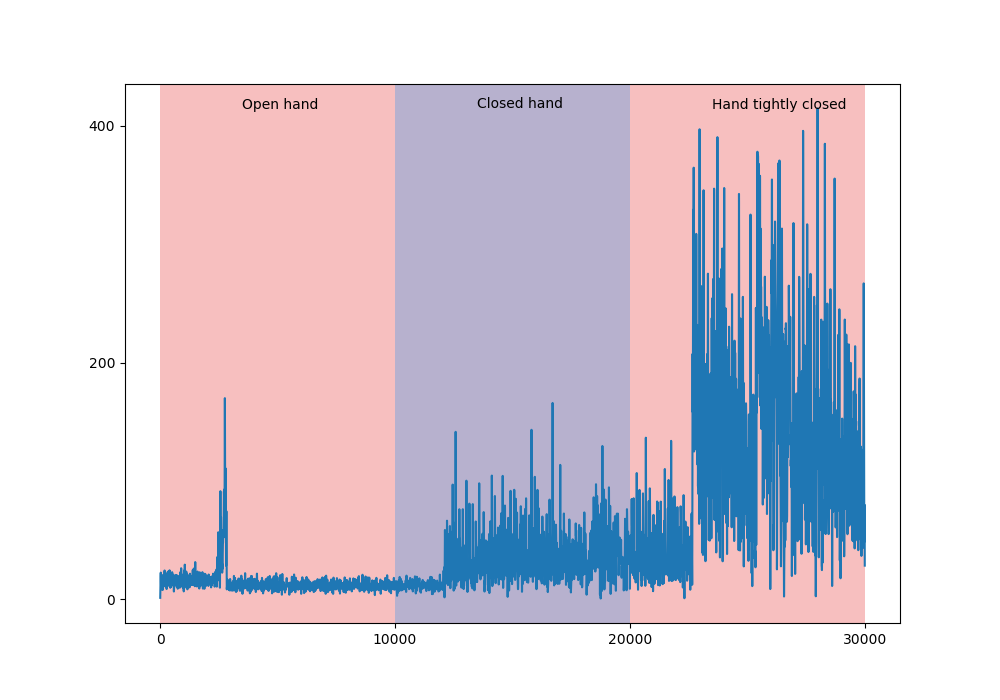


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
data_155743_f_honp.npy
data_155743_f_hclp.npy
data_155743_f_hchp.npy


<IPython.core.display.Javascript object>


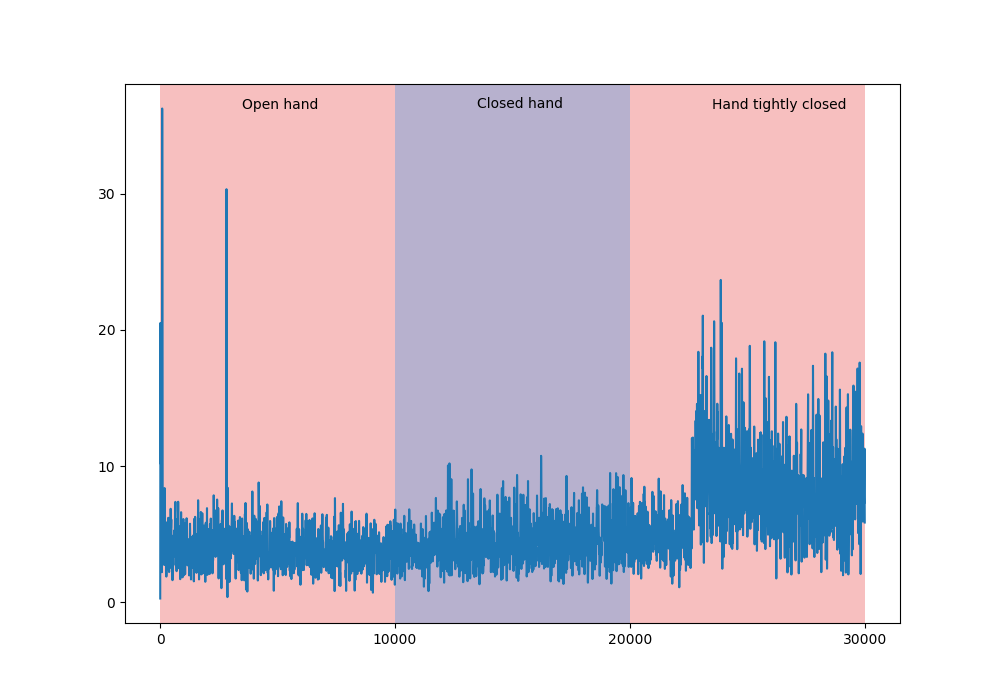


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
data_161034_f_honp.npy
data_161034_f_hclp.npy
data_161034_f_hchp.npy


<IPython.core.display.Javascript object>


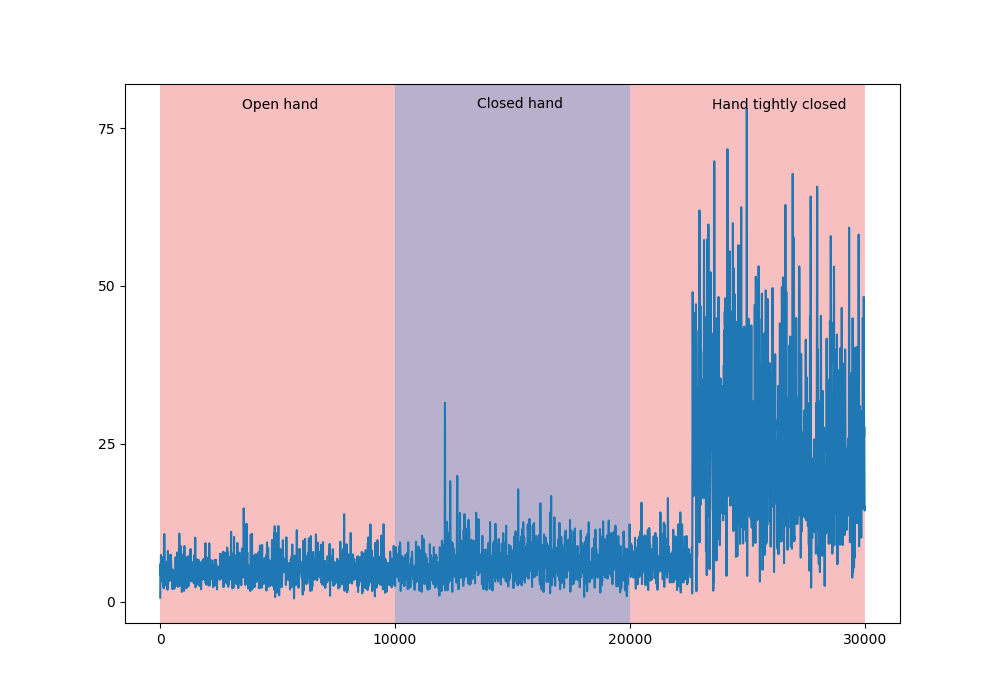


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
data_161420_f_honp.npy
data_161420_f_hclp.npy
data_161420_f_hchp.npy
Tempo total para o envelopamento: 3.17 min


In [50]:
files = ['data_154743','data_155334','data_155743','data_161034', 'data_161420']
DATA = []

start = timeit.default_timer()

for i in files:
    proccess_data(i,DATA)

stop = timeit.default_timer()

ti = stop - start 
print ('Tempo total para o envelopamento: %.2f min' % (ti/60))

In [213]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

In [51]:
Xc = np.load("preproc_filtered_data/"+DATA[0])
for i in DATA[1:]:
    Xc = np.vstack((Xc,np.load("preproc_filtered_data/"+i))) 

In [52]:
np.save('./preproc_filtered_data/row_data', Xc, allow_pickle=False)
print 'Xc saved as row_data.npy'

Xc saved as row_data.npy


---

# --- Start ---

In [4]:
Xc = np.load("preproc_filtered_data/row_data.npy")

In [5]:
Xc.shape

(97515, 501)

In [6]:
X = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
y = np.array([])
for i in range(len(yz)):
    y = np.hstack((y,yz[i]))

X.shape, y.shape

((97515, 499), (97515,))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)
#X_valid_std = sc.transform(X_valid)

In [9]:
print X_train.shape, y_train.shape, X_test.shape

(73136, 499) (73136,) (24379, 499)


# Random Forest Classifier

In [10]:
#Training
print 'Training process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600, n_jobs=4, max_features='log2', 
                             warm_start=True)
rfc = rfc.fit(X_train_std, y_train)

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
send_email(('\n Training process: \n %s \n %s \n %s \n' % (slt, flt, tc)))

Training process:
Started at 11:26:07
Finished at 11:36:11
Total time 10.0 min


In [11]:
#Test
print 'Predicting process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

y_pred = rfc.predict(X_test_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Predict process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Predicting process:
Started at 11:36:16
Finished at 11:36:25
Total time 0.15 min
ClassifyRF accuracy:---------->99.79 %


### Validation

<IPython.core.display.Javascript object>


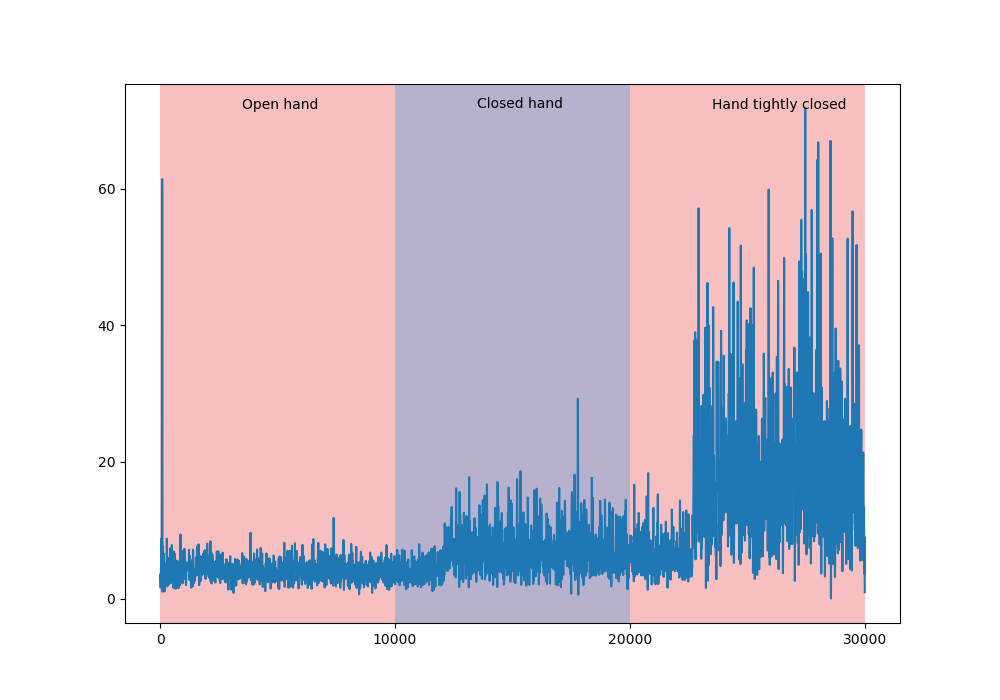


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
bru_data_170623_f_honp.npy
bru_data_170623_f_hclp.npy
bru_data_170623_f_hchp.npy


<IPython.core.display.Javascript object>


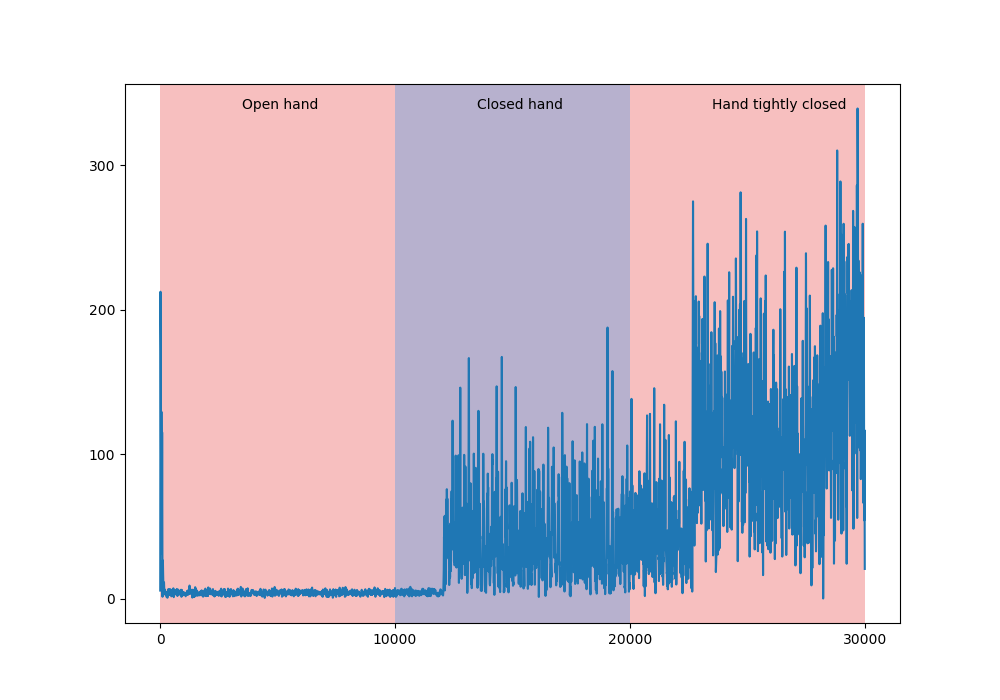


Xc_1 filtered shape  (7000,)
Xc_2 filtered shape  (7000,)
Xc_3 filtered shape  (7000,)
Xc_1 temporal-serie shape  (6501, 500)
Xc_2 temporal-serie shape  (6501, 500)
Xc_3 temporal-serie shape  (6501, 500)
Xc_1 labeled shape  (6501, 501)
Xc_2 labeled shape  (6501, 501)
Xc_3 labeled shape  (6501, 501)
rob_data_170159_f_honp.npy
rob_data_170159_f_hclp.npy
rob_data_170159_f_hchp.npy


In [61]:
DATAV = []
val_set = ['bru_data_170623', 'rob_data_170159']
for i in val_set:
    proccess_data(i ,DATAV)

In [12]:
#DATAV = ['rob_data_170159_f_honp.npy', 'rob_data_170159_f_hclp.npy', 'rob_data_170159_f_hchp.npy']
#DATAV = ['bru_data_170623_f_honp.npy', 'bru_data_170623_f_hclp.npy', 'bru_data_170623_f_hchp.npy']
DATAV = ['rob_data_170159_f_honp.npy', 'rob_data_170159_f_hclp.npy', 'rob_data_170159_f_hchp.npy', 'bru_data_170623_f_honp.npy', 'bru_data_170623_f_hclp.npy', 'bru_data_170623_f_hchp.npy']

In [13]:
Xc = np.load("preproc_filtered_data/"+DATAV[0])
for i in DATAV[1:]:
    Xc = np.vstack((Xc,np.load("preproc_filtered_data/"+i)))
    
Xvalid = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
yvalid = np.array([])
for i in range(len(yz)):
    yvalid = np.hstack((yvalid,yz[i]))

print Xvalid.shape, yvalid.shape

(39006, 499) (39006,)


In [14]:
#Validation
print 'Validation process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = rfc.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Validation process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Validation process:
Started at 11:36:29
Finished at 11:36:40
Total time 0.17 min
ClassifyRF accuracy:---------->95.39 %


## Confusion Matrix

<IPython.core.display.Javascript object>


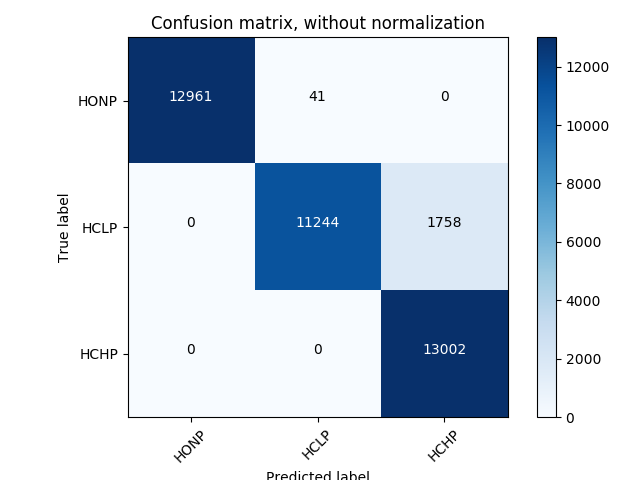

Confusion matrix, without normalization
[[12961    41     0]
 [    0 11244  1758]
 [    0     0 13002]]


<IPython.core.display.Javascript object>


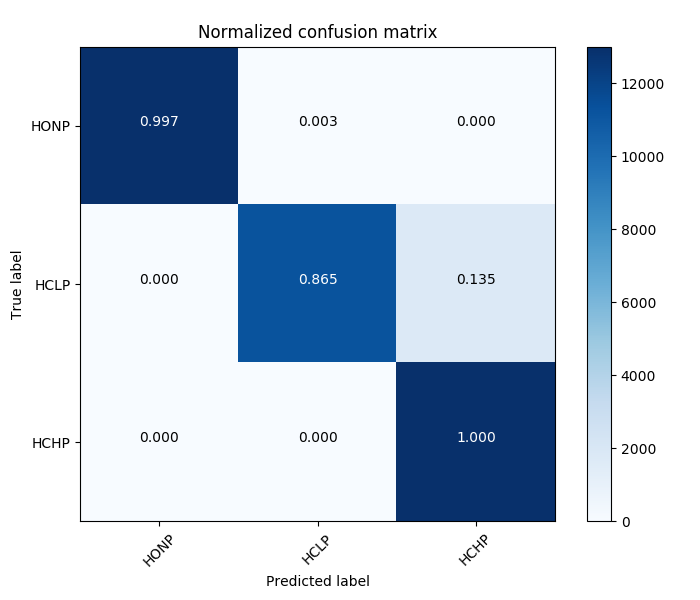

Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    0.86  0.14]
 [ 0.    0.    1.  ]]


In [15]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

%matplotlib notebook
class_names = np.array(['HONP', 'HCLP', 'HCHP'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, ('%.3f' % cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    print(cm)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(yvalid, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig_name = 'cm.png'
fig.set_size_inches(w=7,h=6)
fig.savefig(fig_name)

plt.show()

In [16]:
cm = confusion_matrix(yvalid, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
TPa = float(cm[0][0])
Eab = float(cm[0][1])
Eac = float(cm[0][2])
#####################
Eba = float(cm[1][0])
TPb = float(cm[1][1])
Ebc = float(cm[1][2])
#####################
Eca = float(cm[2][0])
Ecb = float(cm[2][1])
TPc = float(cm[2][2])

Pa = TPa/(TPa+Eba+Eca)
Pb = TPb/(TPb+Eab+Ecb)
Pc = TPc/(TPc+Eac+Ebc)

Ra = TPa/(TPa+Eab+Eab)
Rb = TPb/(TPb+Eba+Ebc)
Rc = TPc/(TPc+Eca+Ecb)

TNa = TPb+Ebc+Ecb+TPc
TNb = TPa+Eac+Eca+TPc
TNc = TPa+Eab+Eba+TPb

Sa = TNa/(TNa+Eba+Eca)
Sb = TNb/(TNb+Eab+Eac)
Sc = TNc/(TNc+Eac+Ebc)

Acc = (TPa+TPb+TPc)/(TPa+Eab+Eac+Eba+TPb+Ebc+Eca+Ecb+TPc)

print 'PERFORMANCE MEASURES BY CONFUSION MATRIX'
acc = ('Accuracy: %.2f %%' % (Acc*100))
print acc 
print ''
sa = ('Sensitivity-A: %.2f %%' % (Ra*100))
print sa 
sb = ('Sensitivity-B: %.2f %%' % (Rb*100))
print sb
sc = ('Sensitivity-C: %.2f %%' % (Rc*100))
print sc
print ''
pa = ('Precision-A: %.2f %%' % (Pa*100))
print pa
pb = ('Precision-B: %.2f %%' % (Pb*100))
print pb
pc = ('Precision-C: %.2f %%' % (Pc*100))
print pc
print ''
spa = ('Specificity-A: %.2f %%' % (Sa*100))
print spa
spb = ('Specificity-B: %.2f %%' % (Sb*100))
print spb
spc = ('Specificity-C: %.2f %%' % (Sc*100))
print spc

PERFORMANCE MEASURES BY CONFUSION MATRIX
Accuracy: 95.39 %

Sensitivity-A: 99.37 %
Sensitivity-B: 86.48 %
Sensitivity-C: 100.00 %

Precision-A: 100.00 %
Precision-B: 99.64 %
Precision-C: 88.09 %

Specificity-A: 100.00 %
Specificity-B: 99.84 %
Specificity-C: 93.24 %


In [17]:
send_email(('\n Validation process: \n %s \n %s \n %s \n\n PERFORMANCE MEASURES BY CONFUSION MATRIX \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n' % (slt, flt, tc, acc, sa, sb, sc, pa, pb, pc, spa, spb, spc)), 'cm.png')


# Support Vector Machine

In [171]:
#Training

from sklearn import svm, datasets

print 'Processing time SVM'
%time svm = svm.SVC(kernel='rbf', gamma=0.2, C=6, decision_function_shape='ovr').fit(X_train_std, y_train)

print ''

from sklearn.metrics import accuracy_score

Processing time SVM
CPU times: user 2h 10min 30s, sys: 1.95 s, total: 2h 10min 32s
Wall time: 2h 10min 34s



In [172]:
#Test

print 'Predict time'  
%time y_pred = svm.predict(X_test_std)
from sklearn.metrics import accuracy_score
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

Predict time
CPU times: user 10min 36s, sys: 84 ms, total: 10min 36s
Wall time: 10min 36s
SVM-RBF accuracy:---------->94.67 %


In [174]:
#Validation

print 'Predict time'  
%time y_pred = svm.predict(X_valid_std)
from sklearn.metrics import accuracy_score
print ('SVM-RBF accuracy:---------->%.2f %%' % (accuracy_score(yvalid, y_pred)*100))

Predict time
CPU times: user 18min 34s, sys: 1.1 s, total: 18min 35s
Wall time: 18min 37s
SVM-RBF accuracy:---------->75.47 %


# GridSearch

In [ ]:
from sklearn.grid_search import GridSearchCV
param_grid = [
    {
        'C'     : [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000], 
        'gamma' : [1000, 100, 80, 50, 35, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
        'kernel': ['rbf'],
        'random_state' : [1,5,10,100,500,1000,10000]
    },
]    
clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid, cv=15)
%time clf.fit(X_train_std, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

# Gaussian Naive Bayes Classifier

In [163]:
from sklearn.naive_bayes import GaussianNB

gnbc = GaussianNB()
print 'Training time'
%time gnbc.fit(X_train_std, y_train)

pred = gnbc.predict(X_test)

from sklearn.metrics import accuracy_score
print ('ClassifyNB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

Training time
CPU times: user 412 ms, sys: 76 ms, total: 488 ms
Wall time: 488 ms
ClassifyNB accuracy:---------->33.11 %


# Ada Boost Classifier

In [170]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 1.5)
print 'Training time'
%time abc = abc.fit(X_train_std, y_train)
print''

print 'Predict time'
%time pred = abc.predict(X_test_std)

print''

from sklearn.metrics import accuracy_score


print ('ClassifyAB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

Training time
CPU times: user 9min 14s, sys: 192 ms, total: 9min 14s
Wall time: 9min 15s

Predict time
CPU times: user 720 ms, sys: 4 ms, total: 724 ms
Wall time: 721 ms

ClassifyAB accuracy:---------->66.84 %


Training time
CPU times: user 9min 13s, sys: 468 ms, total: 9min 13s
Wall time: 9min 14s

Predict time
CPU times: user 788 ms, sys: 8 ms, total: 796 ms
Wall time: 796 ms

ClassifyAB accuracy:---------->66.75 %


In [166]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print 'Training time'
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=2, max_features='sqrt'), algorithm="SAMME", n_estimators=600)

%time bdt.fit(X_train_std, y_train)

print 'Predict time'
%time pred = bdt.predict(X_test_std)

print''
print ('ClassifyAB accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = bdt.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))
print acc

Training time
CPU times: user 4.28 s, sys: 8 ms, total: 4.29 s
Wall time: 4.29 s
Predict time
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 27.5 ms

ClassifyAB accuracy:---------->92.83 %
ClassifyRF accuracy:---------->71.89 %


# KNeighbors Classifier

In [227]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', p=10, n_jobs=4)
print 'Training time'
%time knc = knc.fit(X_train_std, y_train)
print''

print 'Predict time'
%time pred = knc.predict(X_test_std)

print''

from sklearn.metrics import accuracy_score



print ('ClassifyKN accuracy:---------->%.2f %%' % (accuracy_score(y_test, pred)*100))

Training time
CPU times: user 4.5 s, sys: 0 ns, total: 4.5 s
Wall time: 4.54 s

Predict time
CPU times: user 9h 25min 35s, sys: 24 s, total: 9h 25min 59s
Wall time: 2h 31min 19s

ClassifyKN accuracy:---------->99.89 %


In [228]:
print 'Predict time'
%time pred = knc.predict(X_valid_std)

print''

from sklearn.metrics import accuracy_score



print ('ClassifyKN accuracy:---------->%.2f %%' % (accuracy_score(y_test[:len(X_valid_std)], pred)*100))

Predict time
CPU times: user 5h 30min 53s, sys: 8.94 s, total: 5h 31min 2s
Wall time: 1h 57min

ClassifyKN accuracy:---------->33.21 %


# Decision Tree

In [160]:
print 'Training process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

from sklearn import tree
dtc = tree.DecisionTreeClassifier(min_samples_split=2, max_features='sqrt')
dtc = dtc.fit(X_train_std, y_train)

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc

Training process:
Started at 10:12:16
Finished at 10:12:20
Total time 0.06 min


In [161]:
print 'Predicting process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

y_pred = dtc.predict(X_test_std)
from sklearn.metrics import accuracy_score
print ('ClassifyDT accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc

Predicting process:
Started at 10:12:24
ClassifyDT accuracy:---------->92.54 %
Finished at 10:12:24
Total time 0.00 min


In [162]:
#Validation
print 'Validation process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = dtc.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc

Validation process:
Started at 10:12:30
Finished at 10:12:30
Total time 0.01 min
ClassifyRF accuracy:---------->71.77 %


In [362]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

In [158]:
def plot_right(file_):    
    data = np.load('DB_HAND/'+file_+'.npy')
    Xc_1 = data[3000:10000]
    Xc_2 = data[13000:20000]
    Xc_3 = data[23000:]
    
    AA = Xc_1
    AA = np.vstack((AA,Xc_2))
    AA = np.vstack((AA,Xc_3))
    data = filter_signal(AA[:,0], low_pass=180)
    
    # plot graphs
    fig = plt.figure()
    plt.title('Filtered, rectified ' + '\n' + 'EMG envelope: ' + str(int(180)) + ' Hz')
    plt.plot(data)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='y', nbins=4)
    plt.axvspan(.0, 6999, facecolor='#F08080', alpha=0.5)
    plt.axvspan(7000, 13999, facecolor='#70659e', alpha=0.5)
    plt.axvspan(14000, 21000, facecolor='#F08080', alpha=0.5)
    plt.annotate('Open hand', xy=(2000, data.max()))  
    plt.annotate('Closed hand', xy=(9000, data.max()))
    plt.annotate('Hand tightly closed', xy=(17000, data.max()))
    
    fig_name = file_+'_filtered'+str(180)+'.png'
    fig.set_size_inches(w=10,h=7)
    fig.savefig(fig_name)

<IPython.core.display.Javascript object>


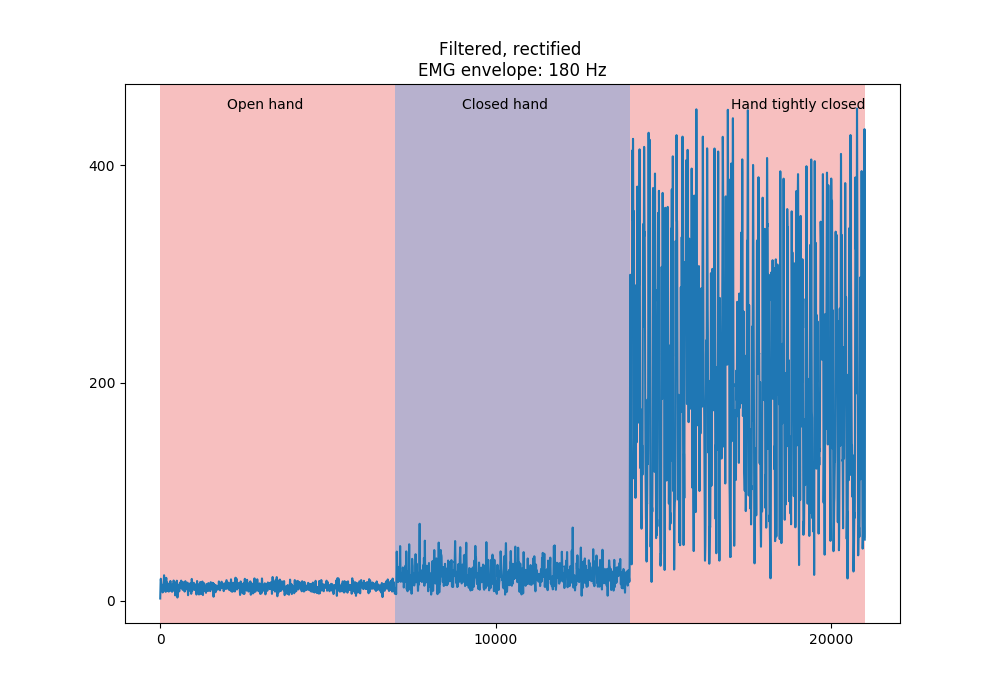

<IPython.core.display.Javascript object>


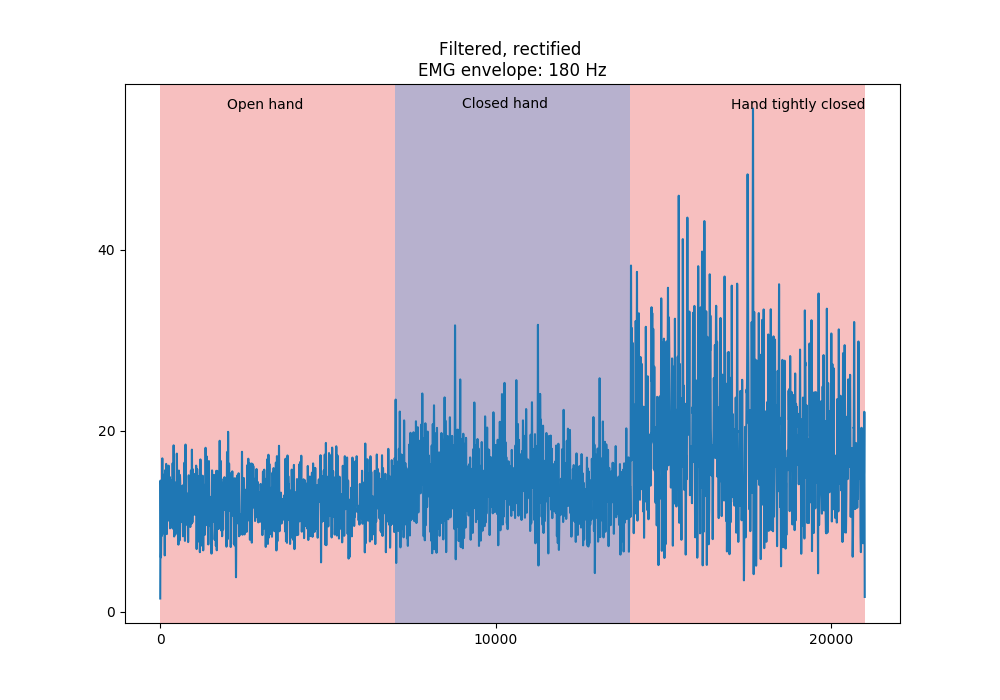

<IPython.core.display.Javascript object>


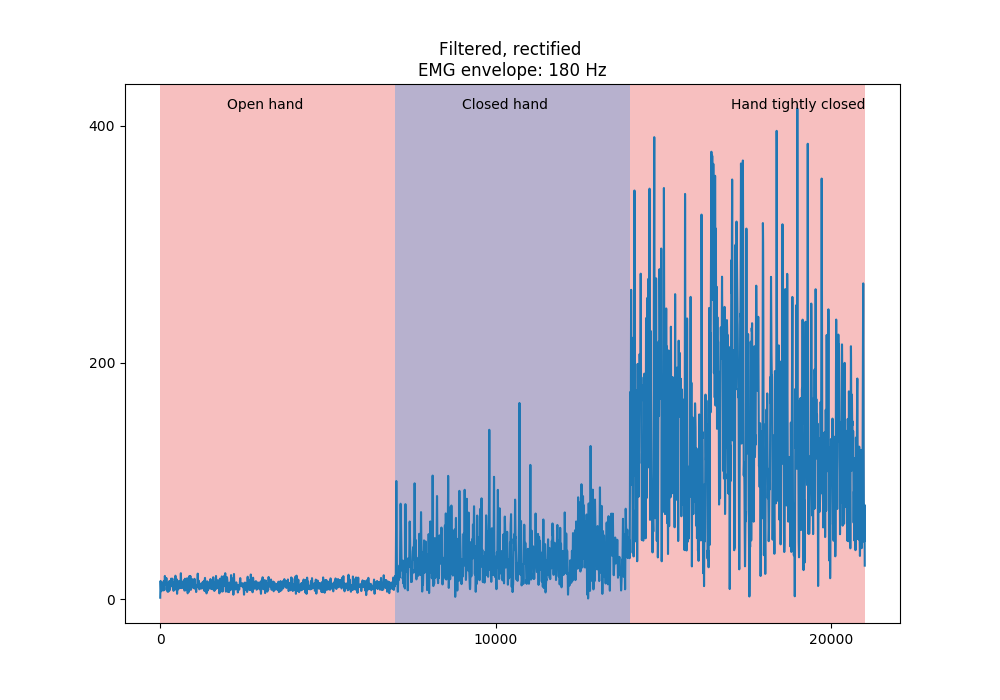

<IPython.core.display.Javascript object>


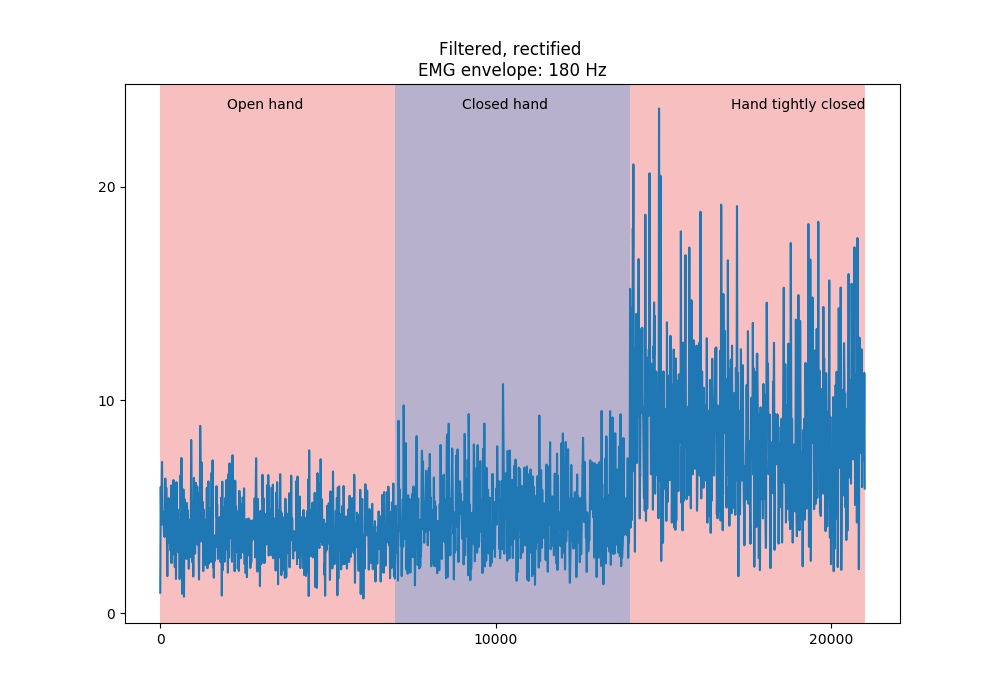

<IPython.core.display.Javascript object>


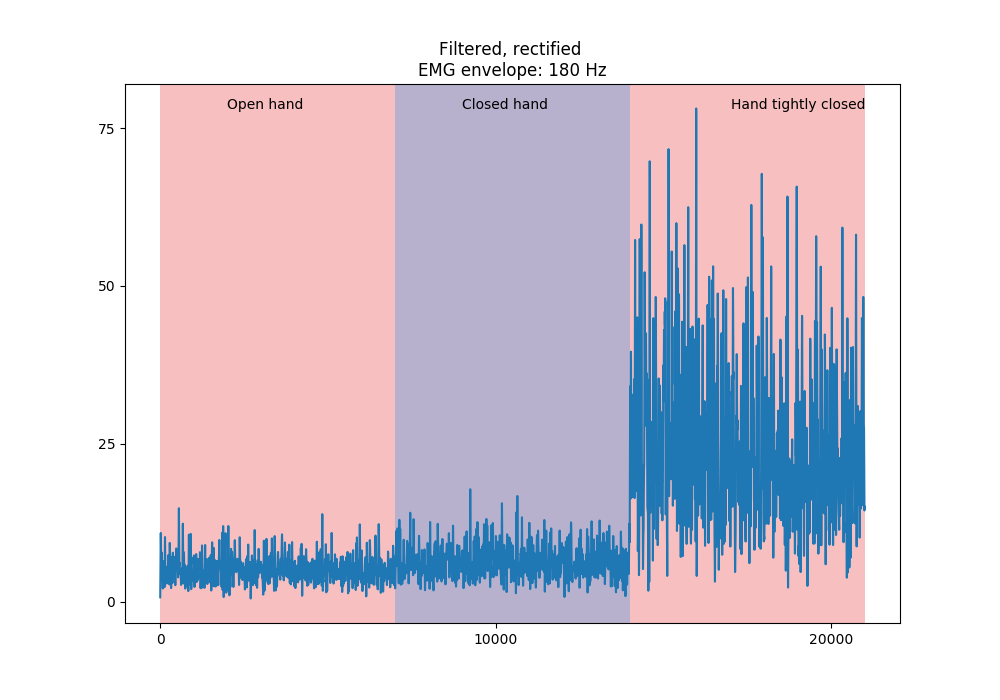

<IPython.core.display.Javascript object>


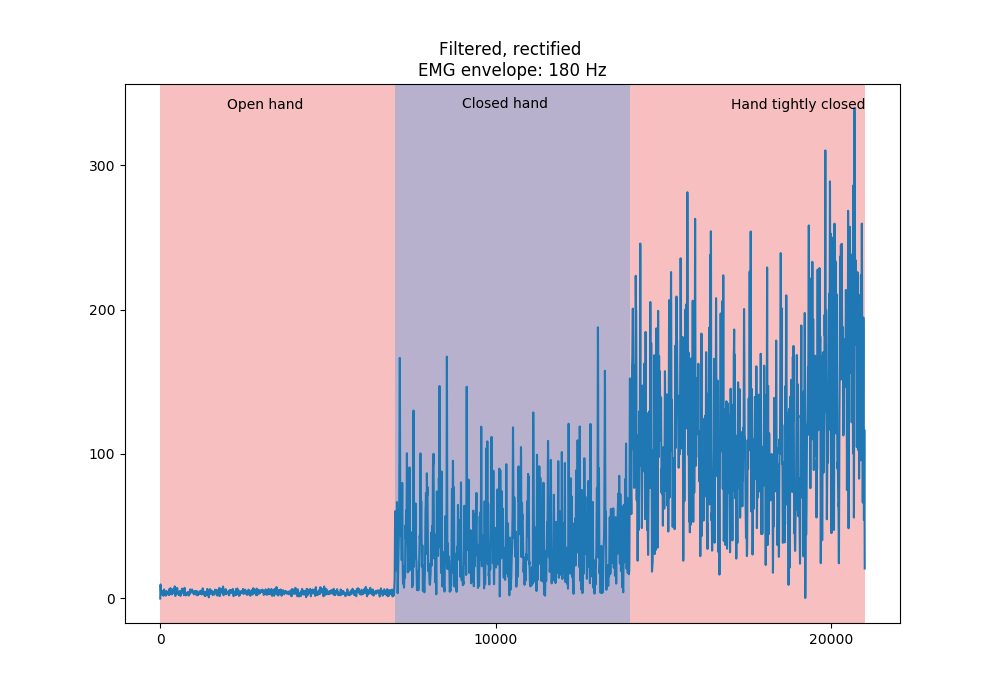

<IPython.core.display.Javascript object>


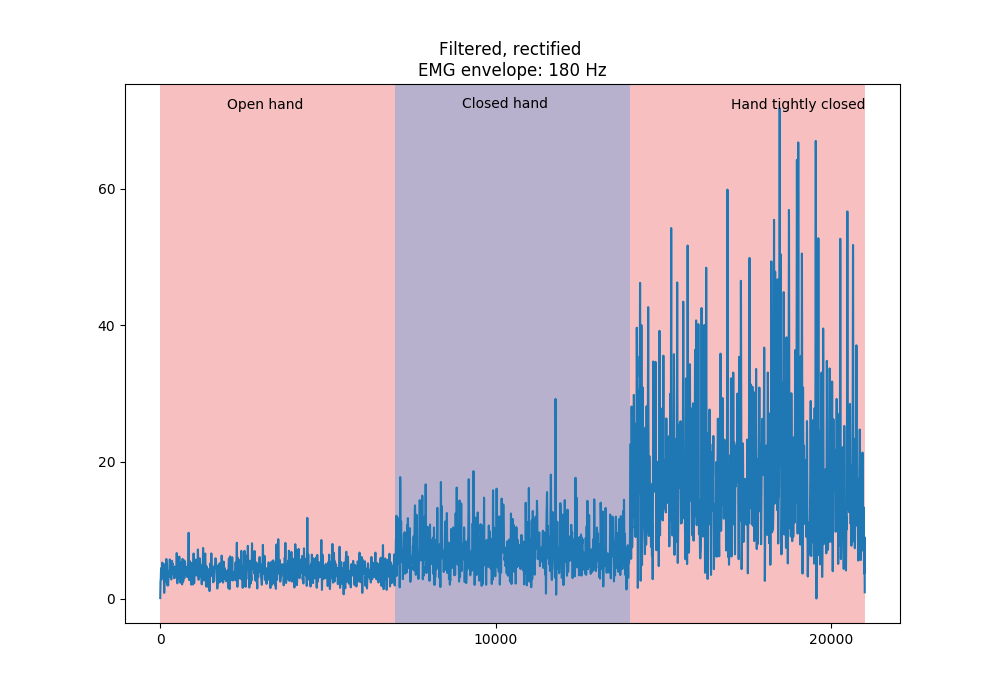

In [159]:
for i in files:
    plot_right(i)